# Partial Dependency Plot Examples Notebook

The partial dependency plot is useful to understand how a model behaves and to gain insights into how the different features and feature interactions affect predictions. Each plot shows the exact transfer function of a module i.e. the attributions from the module vs the input feature values.

In this example, we will show partial dependency plots for various modules with different numbers and types of input features.

# Check Environment Variables
Before installing Hybrid Intelligence in the notebook you need to set these Environment Variables externally as described in the User Guide https://docs.umnai.com/set-up-your-environment. 
This section checks that the environment variables have been set correctly and throws an error if not.

In [1]:
import os

umnai_env_vars = {
    'UMNAI_CLIENT_ID',
    'UMNAI_CLIENT_SECRET',
    'PIP_EXTRA_INDEX_URL',
}

if not umnai_env_vars.issubset(os.environ.keys()):
    raise ValueError(
        'UMNAI environment variables not set correctly. They need to be set before using the Umnai library.'
    )

# Install Hybrid Intelligence
Next we install the UMNAI Platform.

In [2]:
%pip install umnai-platform --quiet

Note: you may need to restart the kernel to use updated packages.


# Set Workspace Paths According to Your Environment
Now we will set the workspace path and the experiment path automatically. They will be set to a local path if you are using a local machine environment or to a Databricks path if you are using a Databricks environment.

## Install Databricks SDK

This checks if you are running on Databricks and installs their SDK if you are.

In [3]:
import os
if os.environ.get('DATABRICKS_RUNTIME_VERSION') is not None:
    %pip install databricks-sdk --quiet

If you are on Databricks, you can select whether you would like the workspace to be created in the shared area (available to all users in your account) or in your personal user account area. You can ignore this if you are running on a local environment.

In [4]:
# Set to 1 if you want to use shared or 0 to use personal user account area.
USE_SHARED_WORKSPACE = 1 

## Set Paths
Next the workspace and experiment paths are set automatically.

In [5]:
import os

EXP_NAME = 'pdplot_adult_income'
if os.environ.get('DATABRICKS_RUNTIME_VERSION') is not None:
    from databricks.sdk import WorkspaceClient
    w = WorkspaceClient()

    # # For a Databricks Environment
    WS_PATH = '/dbfs/FileStore/workspaces/'+EXP_NAME
    if USE_SHARED_WORKSPACE:
        EXP_PREFIX = f'/Shared/experiments/'
    else:
        USERNAME = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
        EXP_PREFIX = f'/Users/{USERNAME}/experiments/'
    w.workspace.mkdirs(EXP_PREFIX)
    EXP_PATH = EXP_PREFIX + EXP_NAME
else:
    # For a Local Machine Environment
    WS_PATH = 'resources/workspaces/'+EXP_NAME
    EXP_PATH = EXP_NAME

# Import and Prepare Dataset
Import the dataset to a Pandas DataFrame and the clean data in preparation for onboarding into Hybrid Intelligence.

In [6]:
import pandas as pd
import numpy as np

# Import Adult Income Dataset to pandas dataframe: 
# This dataset can be downloaded from https://archive.ics.uci.edu/dataset/2/adult 
column_names = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
dataset_df = pd.read_csv('https://raw.githubusercontent.com/umnaibase/umnai-examples/main/data/adult.data', names = column_names)

# Data Preparation:
dataset_df = dataset_df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)    # Remove whitespaces
dataset_df["Income"] = np.where((dataset_df["Income"] == '<=50K'), 0, 1)                # Replace Target values with [0,1]
dataset_df.tail(5)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


# Create or Open a Hybrid Intelligence Workspace
Workspaces are used by the Hybrid Intelligence framework to organize your data and models together in one place.

In [7]:
from umnai.workspaces.context import Workspace

# Open a workspace
ws = Workspace.open(
    path = WS_PATH,
    experiment = EXP_PATH
)

ws # Prints workspace details to confirm created/opened

2023-08-30 14:33:16.038100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 14:33:16.070687: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 14:33:16.071696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 14:33:17.115185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_13504/1204024393.py:4: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  ws = Workspace.open(


# Onboard Hybrid Intelligence Dataset

Onboard the Pandas DataFrame into a Hybrid Intelligence dataset.

In [8]:
from umnai.data.datasets import Dataset
from umnai.data.enums import PredictionType

dataset = Dataset.from_pandas(
    dataset_df,
    prediction_type=PredictionType.CLASSIFICATION,
    features=list(dataset_df.drop(['Income'], axis=1).columns),    # All columns except 'Income' are features
    targets=['Income'],
)

dataset # Prints dataset details to confirm created/opened

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/30 14:33:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[ObservationSpec] - MLFLOW Run ID: e29260f4792a4f44858628c6225b9b81:   0%|          | 0/60 [00:00<?, ?it/s]

23/08/30 14:34:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-08-30 14:34:34.561436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'fnlwgt' with dtype int64 and shape [?,1]
	 [[{{node fnlwgt}}]]
2023-08-30 14:34:34.714985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'HoursPerWeek' with dtype int64 and shape [?,1]
	 [[{{node HoursPerWeek}}]]
2023-08-30 14:34:34.751660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'EducationNum' with dtype int64 and shape [?,1]
	 [[{{node EducationNum}}]

INFO:tensorflow:Assets written to: /opt/atlassian/pipelines/agent/build/demo-notebooks/resources/workspaces/pdplot_adult_income/preprocessing/dataset_name=Dataset_d8581ec0/assets


Dataset(id=88d20c07-84d3-4182-b8d5-c4437c0695c1; name=Dataset_d8581ec0; is_named=False; workspace_id=None)

# Induce a Hybrid Intelligence Model

Pre-induced models are available in the notebook workspace on Github and may be downloaded and saved locally. Using Pre-induced models will speed up the execution of the notebook.

If `LOAD_PREINDUCED_MODEL` is set to `1` (default), the notebook will look for and load the pre-induced model with `ESM_ID`. Otherwise, if set to `0` or the pre-induced model is not found, a new model will be induced and saved to the workspace.

In [9]:
# Set this variable to '1' to load a pre-induced model, otherwise set to '0' to re-induce a new model from the dataset
LOAD_PREINDUCED_MODEL = 1

# Model ID
ESM_ID='Dataset_8f78a481_e657593904ca481ba2a6cf93b22912fd'

#### Load or Induce the Model

In [10]:
from umnai.esm.model import ESM
from umnai.induction.inducer import ModelInducer

# Check if a saved model with the ESM_ID exists. If it exists load it, otherwise induce a new model, save it and print the model and run IDs
if (LOAD_PREINDUCED_MODEL == 1):
    try:    
        esm = ESM.from_workspace(id = ESM_ID)
        print('Pre-induced ESM loaded from workspace: ' + esm.id)
    except OSError:
        print("No model found in workspace.")
        LOAD_PREINDUCED_MODEL = 0

if (LOAD_PREINDUCED_MODEL == 0):
    print("Inducing a new model - this may take some time.")
    # Induce a more realistic model using default Induction parameters:
    model_inducer = ModelInducer(
        max_interactions=16,
        max_interaction_degree=2,
        max_polynomial_degree=2,
        trials=2,
        estimators=2,
        batch_size=512,
        iterations=2,
    )

    # Create an ESM using Induction
    esm = model_inducer.induce(dataset)

    # Save the ESM to your workspace
    esm.save_to_workspace()

    # Note ESM ID and MLFLow Run ID
    print("ESM ID: ", esm.id)
    print("MLflow Run ID: ", esm.producer_run_id)


/usr/local/lib/python3.11/site-packages/keras/layers/serialization.py:265: UmnaiRuntimeWarning: Loading an ESM from an earlier Umnai version: 0.10.0


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_

# Explore The Model

## Partial Dependency Plots
Next we will plot some example module Partial Dependency plots.
You can use matplotlib or any other vizualisation tool to plot attributions as a function of input values.

### First Check the List of Modules in the ESM
Check to confirm that the modules in the example have been created in the ESM. If not, you can change the module names in the example plots.

In [11]:
esm.metadata.modules.to_pandas()["module_name"]

_module_index
0                              Age
1                           fnlwgt
2                     EducationNum
3                      CapitalGain
4                      CapitalLoss
5                     HoursPerWeek
6                        Education
7                           Gender
8                    MaritalStatus
9                    NativeCountry
10                      Occupation
11                            Race
12                    Relationship
13                       WorkClass
14        Education x Relationship
15       Occupation x Relationship
16      MaritalStatus x Occupation
17     EducationNum x Relationship
18    EducationNum x MaritalStatus
19       Education x MaritalStatus
20          Education x Occupation
21      CapitalGain x Relationship
22     HoursPerWeek x Relationship
Name: module_name, dtype: object

### Partial Dependency Plot for a Categorical Feature Module

#### Generate View and Plot Data

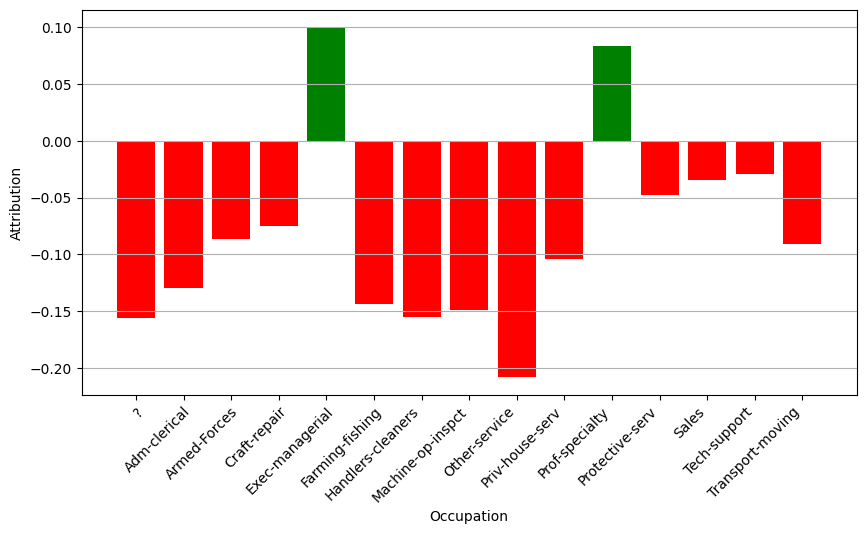

In [12]:
import matplotlib.pyplot as plt
from umnai.views.partial_dependency import PartialDependencyView

# Select a module
selected_module = 'Occupation'

# Generate the view
partial_dependency_view = PartialDependencyView(esm=esm, module=selected_module, use_training_data=False)

# Plot the data
input_vals = partial_dependency_view.data[f'{"input_feature"}.{selected_module}']
attributions = partial_dependency_view.data['attribution.Income']

plt.figure(figsize=(10, 5))
plt.xlabel(selected_module)
plt.xticks(rotation = 45, ha = 'right', rotation_mode='anchor')
plt.ylabel("Attribution")
plt.grid(which='major', axis='y')
colours = ['g' if x >= 0 else 'r' for x in attributions]   # Make colour bars red or green
plt.bar(input_vals, attributions, color=colours)
plt.show()

### Partial Dependency Plot for a Continuous Feature Module

#### Generate View and Plot Data

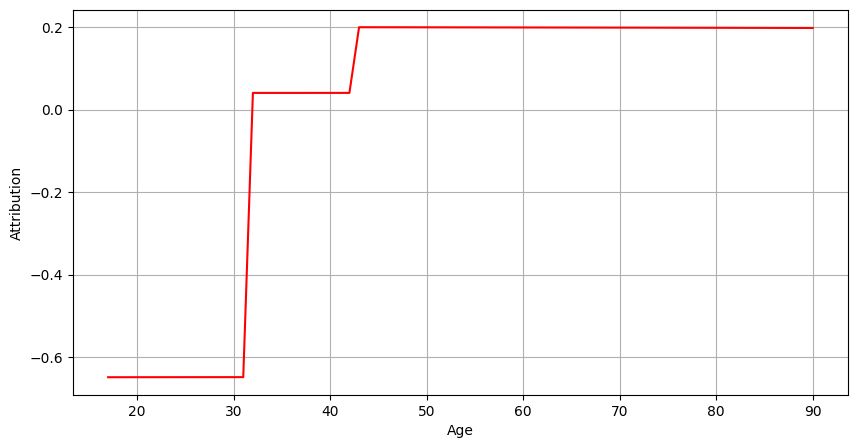

In [13]:
# Select a module
selected_module = 'Age'

# Generate the view
partial_dependency_view = PartialDependencyView(esm=esm, module=selected_module, use_training_data=False)


input_vals = partial_dependency_view.data[f'{"input_feature"}.{selected_module}']
attributions = partial_dependency_view.data['attribution.Income']

plt.figure(figsize=(10, 5))
plt.xlabel(selected_module)
plt.ylabel("Attribution")
plt.grid(which='major', axis='both')
plt.plot(input_vals, attributions, color='r')
plt.show()

### Partial Dependency Plot an Interaction Module with Two Categorical Features

**NOTE:** You may have to change the names of `feature1` and `feature2` to match those of a module with two categorical features from the list of modules generated previously.

#### Generate View and Plot Data

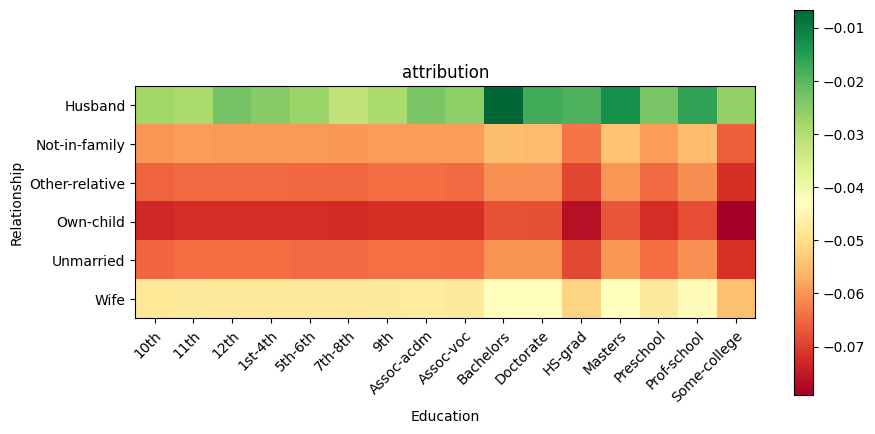

In [14]:
# Select module features:
feature1 = 'Education'
feature2 = 'Relationship'
target='Income'
module_features = [feature1, feature2]

# Generate the view
partial_dependency_view = PartialDependencyView(esm=esm, module=module_features, use_training_data=False)

# Manipulate Plot Data and Titles
input_1 = f'{"input_feature"}.{feature1}'
input_2 = f'{"input_feature"}.{feature2}'
attributions = f'{"attribution"}.{target}'

data_df = partial_dependency_view.data.drop(['attribution_normalized.Income', 'module_partition_index', 'rule_id', 'condition_expr_friendly', 'attribution_delta.Income'], axis=1)
data_df.rename(columns={input_1: module_features[0], input_2: module_features[1], attributions: "attributions"}, inplace=True)
data_table = data_df.pivot(index=module_features[1], columns=module_features[0], values='attributions')

# Plot the heatmap
plt.figure(figsize=(10, 5))
plt.imshow(data_table, cmap="RdYlGn")
 
# Add colorbar
cbar = plt.colorbar()

# Set tick labels
plt.xticks(range(len(data_table.columns)), data_table.columns, rotation = 45, ha = 'right', rotation_mode='anchor')
plt.yticks(range(len(data_table.index)), data_table.index)

# Set plot title and axis labels
plt.title("attribution")
plt.xlabel(feature1)
plt.ylabel(feature2)
 
# Display the plot
plt.show()

### Partial Dependency Plot an Interaction Module with a Categorical Feature and a Continuous Feature
**NOTE:** You may have to change the names of `feature1` and `feature2` to match those of a module with one continuous feature and one categorical feature from the list of modules generated previously.

#### Generate View and Plot Data

<Figure size 640x480 with 0 Axes>

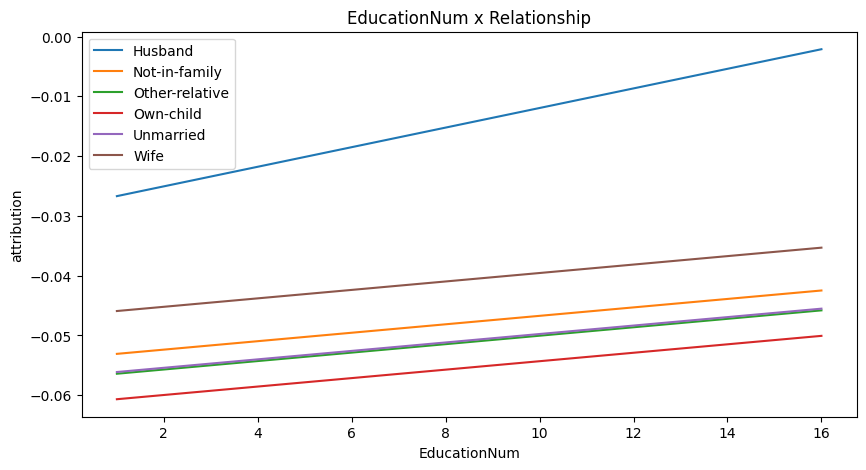

In [15]:
# Select module features:
feature1 = 'EducationNum'
feature2 = 'Relationship'
target = 'Income'
module_features = [feature1, feature2]

# Generate the view
partial_dependency_view = PartialDependencyView(esm=esm, module=module_features, use_training_data=False)

# GENERATE PLOT
# Manipulate Plot Data and Titles
input_1 = f'{"input_feature"}.{feature1}'
input_2 = f'{"input_feature"}.{feature2}'
attributions = f'{"attribution"}.{target}'

partial_dependency_view.data

data_df = partial_dependency_view.data.drop(['attribution_normalized.Income', 'module_partition_index', 'rule_id', 'condition_expr_friendly', 'attribution_delta.Income'], axis=1)
data_df.rename(columns={input_1: module_features[0], input_2: module_features[1], attributions: "attributions"}, inplace=True)
data_table = data_df.pivot(index=module_features[1], columns=module_features[0], values='attributions')

plt.figure()
data_table.T.plot.line(figsize=(10, 5))
# Set plot title and axis labels
plt.title(feature1 + ' x ' + feature2)
plt.xlabel(feature1)
plt.ylabel("attribution")
plt.legend(loc='best')
plt.show()